# Homework 2 (Kaveh)
Climate Modeling, ATS 421/521, Spring 2018

## Draft due Apr. 19; Final due Apr. 24

Start by specifing inline plots and import all the modules you'll need.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## 1. Using your model from Homework 1, calculate the hysteresis curve (i.e., plot T as a function of S). 
Choose values of S such that you include both the full upper and lower branches. (Make sure that your model converges to equilibrium for your different values of S.)

In [2]:
s_b_constant = 5.67 * 10 ** -8     # Stefan-boltzmann constant (W/(m2.K4))
effective_emiss = 0.614            # Effective emissivity (W/m2)
f_2x_co2 = 3.7                     # Radiative forcing due to doubling of CO2 (W/m2)

albedo_min=0.3
albedo_max=0.7
temperature_upper=280
temperature_lower=250
m = (albedo_max - albedo_min) / (temperature_upper - temperature_lower)    # slope of albedo function (a(t))

def albedo(temperature):
    # calculate albedo using a given temperature
    if temperature < temperature_lower:
        return albedo_max
    elif temperature > temperature_upper:
        return albedo_min
    else:
        return albedo_min + m * (temperature_upper - temperature)

def OLR(temperature):
    """ Calculates Outgoing Longwave Radiation """
    return effective_emiss * s_b_constant * (temperature ** 4)


def ASR(temperature, solar_constant):
    """ Calculates Absorbed Solar Radiation """
    return (1 - albedo(temperature)) * solar_constant


def calculate_temperature(
    current_temperature,
    solar_constant=342,
    heat_capacity=2.2 * 10 ** 8,
    delta_time=1,
    temp_equilibrium_threshold=0.000001,
    max_steps=100000
):
    """ Calculates equilibrium temperature.
    
    Input arguments:
        - current_temperature: K
        - solar_constant: W/m2
        - heat_capacity: Heat capacity of water (oceans) and air (J/(m2.K))
        - delta_time: days
        - temp_equiblirium_threshold: if changes in temperature are below this threshold, we are in an equilibrium state

    Returns a tuple of three items: (equilibrium_temperature, model_time, temp_series):
        - equilibrium_temperature: K
        - model_time: a list containing `days` it takes to reach equilibrium
        - temp_Series: a list containing updated temperature after step
    """
    delta_time = delta_time * 86400     # convert days to seconds
    delta_temp = 1                      # the initial temperature difference; an arbitrary value that makes sure the while loop below runs at least once
    steps = 0
    
    model_time=[]
    temp_series=[]

    while (abs(delta_temp) > temp_equilibrium_threshold) and steps < max_steps:
        temp_series.append(current_temperature)
        model_time.append(steps * delta_time / 86400)
        steps += 1
        radiative_flux = ASR(current_temperature, solar_constant) - OLR(current_temperature)
        delta_temp = radiative_flux * delta_time / heat_capacity
        current_temperature = current_temperature + delta_temp

    return current_temperature, model_time, temp_series

"""
All variables with `asc` suffix are used for calculating temperatures correspond to
ascending solar constant (lower branch of hysteresis), and `desc` corresponds to
descending solar constants (upper branch of hysteresis).
"""
init_temp_asc = 205      # (K)
init_temp_desc = 315     # (K)
solar_constants_asc = np.linspace(200, 500, 400)    # W/m2
solar_constants_desc = np.linspace(500, 200, 400)   # W/m2
temps_asc = []
temps_desc = []
for solar_constant_asc, solar_constant_desc in zip(solar_constants_asc, solar_constants_desc):
    init_temp_asc, _, _ = calculate_temperature(init_temp_asc, solar_constant_asc)
    init_temp_desc, _, _ = calculate_temperature(init_temp_desc, solar_constant_desc)
    temps_asc.append(init_temp_asc)
    temps_desc.append(init_temp_desc)

a. Plot the hysteresis curve (Temperature vs Solar Constant)

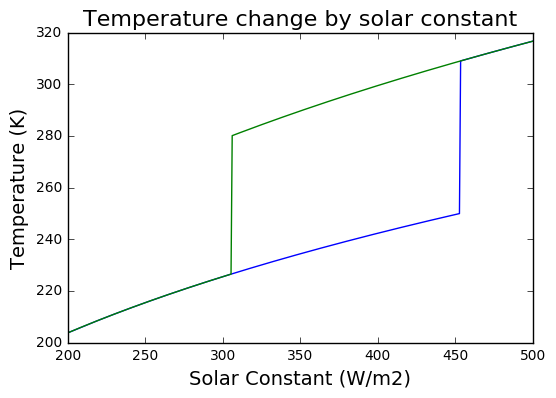

In [3]:
plt.title('Temperature change by solar constant', fontsize=16)
plt.xlabel('Solar Constant (W/m2)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)
plt.plot(solar_constants_asc, temps_asc)
plt.plot(solar_constants_desc, temps_desc)
plt.show()

b. Describe how T depends on S.

When we increase solar constant, absorbed solar radiation rises too. After a solar constant of about 453.5 W/m2, ASR intersects OLR only at one point and stable equilibrium can be achieved at a higher point. That's why there's a jump at the mentioned solar constant. The same thing happens when we decrease solar constant.

## 2. Calculate the values of S that correspond to equilibrium (either stable or unstable) for your range of T values.

(That is, $S= \kappa \sigma T^4/(1-\alpha)$.)

In [4]:
temps = np.linspace(205, 316, 75)    # K
solar_constants = []                 # collection of solar constants corresponding to a given equilibrium (W/m2)
for temp in temps:
    solar_constants.append(s_b_constant * effective_emiss * temp ** 4 / (1 - albedo(temp)))

a. Plot the S values on the same plot as the hysteresis curve from part 1. (You can combine this with the plot in part 1a.)

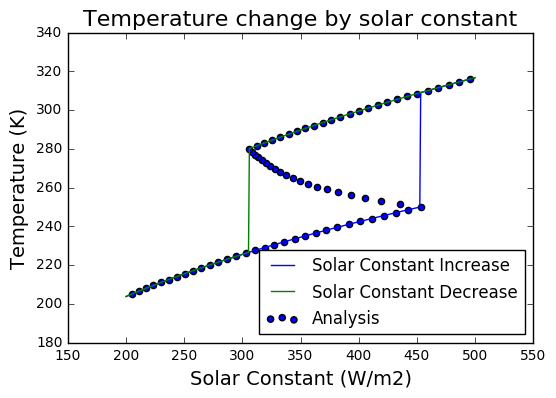

In [5]:
plt.title('Temperature change by solar constant', fontsize=16)
plt.xlabel('Solar Constant (W/m2)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)
plt.plot(solar_constants_asc, temps_asc, label='Solar Constant Increase')
plt.plot(solar_constants_desc, temps_desc, label='Solar Constant Decrease')
plt.scatter(solar_constants, temps, label='Analysis')
plt.legend(loc='best')

b. Compare and contrast the two curves and explain why they differ. 

For a given equilibrium temperature there's only one solar constant, because ASR, and therefore solar constant, depend only on temperature.
The reverse relation depends on intersection of ASR and OLR, which can happen at more than one point. So a solar constant can give us two equilibrium temperature, depending on the previous temperature of our model.

## 3.	Study the response of your 0D-EBM to forcing. asdasdasdsad

a. Calculate the warm equilibrium state for the present solar constant (342 Wm⁻²).  [You want to make sure the model is in equilibrium before you add the forcing!]  

In [6]:
equilibrium_temp_default, model_time_default, temp_series_default = calculate_temperature(275)
print('Warm equilibrium: {:0.2f} K'.format(equilibrium_temp_default))

Warm equilibrium: 287.97 K


b. Add a radiative forcing that corresponds to a doubling of atmospheric CO$_2$, run the model until the system reaches a new steady state, and plot the temperature as a function of time.

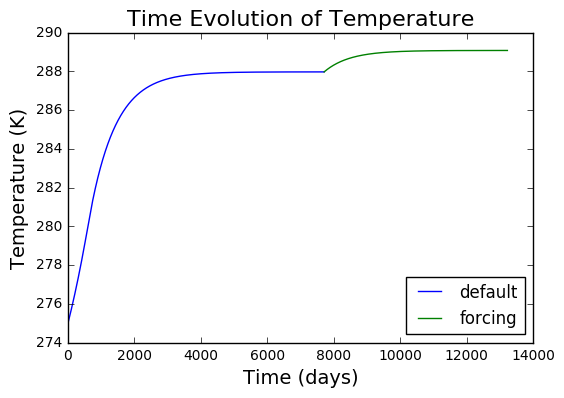

In [7]:
# `init_step` is the last step of previous run of our model.
# It is used by the updated temperature function so its plot can be added to the end of the other plot.
init_step = len(model_time_default)

def calculate_temperature_with_forcing(
    current_temperature,
    solar_constant=342,
    heat_capacity=2.2 * 10 ** 8,
    delta_time=1,
    temp_equilibrium_threshold=0.000001,
    max_steps=100000
):
    """
    See `calculate_temperature` in the first code cell in Section 1 for description of arguments.
    The difference with the original function is this one adds forcing to radiative flux (W/m2).
    See `radiative_flux` in `while` loop.
    """
    delta_time = delta_time * 86400
    delta_temp = 1
    steps = init_step
    
    temp_series=[]
    model_time=[]

    while (abs(delta_temp) > temp_equilibrium_threshold) and steps < max_steps:
        temp_series.append(current_temperature)
        model_time.append(steps * delta_time / 86400)
        steps += 1
        radiative_flux = ASR(current_temperature, solar_constant) - OLR(current_temperature) + f_2x_co2
        delta_temp = radiative_flux * delta_time / heat_capacity
        current_temperature = current_temperature + delta_temp

    return current_temperature, model_time, temp_series

equilibrium_temp_forcing, model_time_forcing, temp_series_forcing = calculate_temperature_with_forcing(
    equilibrium_temp_default
)

plt.title('Time Evolution of Temperature', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)
plt.plot(model_time_default, temp_series_default, label='default')
plt.plot(model_time_forcing, temp_series_forcing, label='forcing')
plt.legend(loc='best')

c. What is the climate sensitivity of your model?

In [8]:
print('Climate sensitivity: {:0.2f} K'.format(equilibrium_temp_forcing - equilibrium_temp_default))

Climate sensitivity: 1.11 K


d.	Double the heat capacity, repeat the experiment (i.e., run the model to equilibrium for the control and doubled CO₂ climates), and plot both doubled CO₂ timeseries (from 3b. and 3d.) in one graph.

In [9]:
# 2xc suffix indicates values that are calculated with doubled heat capacity
heat_capacity_doubled = 2 * (2.2 * 10 ** 8)
equilibrium_temp_2xc, model_time_2xc, temp_series_2xc = calculate_temperature(
    275,
    heat_capacity=heat_capacity_doubled
)

print('Warm equilibrium: {:0.2f} K'.format(equilibrium_temp_2xc))

init_step = len(model_time_2xc)
equilibrium_temp_forcing_2xc, model_time_forcing_2xc, temp_series_forcing_2xc = calculate_temperature_with_forcing(
    equilibrium_temp_2xc,
    heat_capacity=heat_capacity_doubled
)

Warm equilibrium: 287.97 K


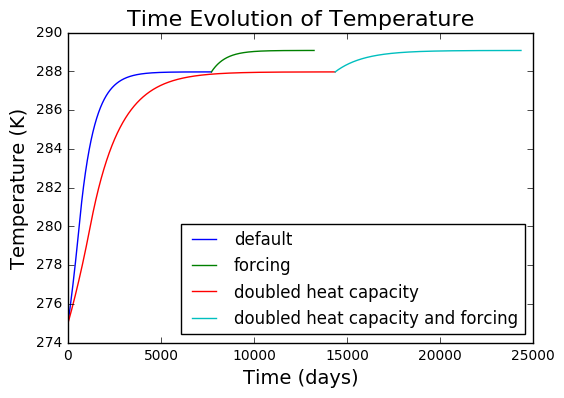

In [10]:
plt.title('Time Evolution of Temperature', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)
plt.plot(model_time_default, temp_series_default, label='default')
plt.plot(model_time_forcing, temp_series_forcing, label='forcing')
plt.plot(model_time_2xc, temp_series_2xc, label='doubled heat capacity')
plt.plot(model_time_forcing_2xc, temp_series_forcing_2xc, label='doubled heat capacity and forcing')
plt.legend(loc='best')

e. Discuss the results. Did the climate sensitivity change when you changed the heat capacity? Why or why not? What did change? 

In [11]:
print('Climate sensitivity (default): {:0.2f} K'.format(equilibrium_temp_forcing - equilibrium_temp_default))
print('Climate sensitivity (doubled heat capacity): {:0.2f} K'.format(equilibrium_temp_forcing_2xc - equilibrium_temp_2xc))

Climate sensitivity (default): 1.11 K
Climate sensitivity (doubled heat capacity): 1.11 K


Double heat capacity did not change climate sensitivity. Increasing heat capacity only increases the time it takes to reach equilibrium. Heat capacity does not affect ASR or OLR. It's an indicator of how long it takes to warm up or cool down an object.

## 4.	Study the response of the new "LW-feedback" 0D-EBM to forcing.

Return to the **original heat capacity**. 

Use the revised calculation for the outgoing longwave radiation: (A = -246 Wm⁻²; B = 1.67 Wm⁻²K⁻1; OLR=A+BT; See Lecture 3). This implicitly includes some longwave feedbacks. 

a. Calculate the new equilibrium temperature.

In [12]:
def OLR_LW_feedback(temperature):
    return -246 + 1.67 * temperature


def ASR(temperature, solar_constant):
    return (1 - albedo(temperature)) * solar_constant


def calculate_temperature_olr_lw_feedback(
    current_temperature,
    solar_constant=342,
    heat_capacity=2.2 * 10 ** 8,
    delta_time=1,
    temp_equilibrium_threshold=0.000001,
    max_steps=100000
):
    """
    See `calculate_temperature` in the first code cell in Section 1 for description of arguments.
    The difference with the original function is this one uses revised OLR function (LW feedback).
    """
    delta_time = delta_time * 86400
    delta_temp = 1
    steps = 0
    
    temp_series=[]
    model_time=[]

    while (abs(delta_temp) > temp_equilibrium_threshold):
        temp_series.append(current_temperature)
        model_time.append(steps * delta_time / 86400)
        steps += 1
        radiative_flux = ASR(current_temperature, solar_constant) - OLR_LW_feedback(current_temperature)
        delta_temp = radiative_flux * delta_time / heat_capacity
        current_temperature = current_temperature + delta_temp
    
    return current_temperature, model_time, temp_series

equilibrium_temp_olr_lw_feedback, model_time_olr_lw_feedback, temp_series_olr_lw_feedback = calculate_temperature_olr_lw_feedback(275)
print('Equilibrium temperature: {:0.2f} K'.format(equilibrium_temp_olr_lw_feedback))

Equilibrium temperature: 290.66 K


b. Add the forcing and calculate the new equilibrium.

In [13]:
init_step = len(model_time_olr_lw_feedback)

def calculate_temperature_olr_lw_feedback_forcing(
    current_temperature,
    solar_constant=342,
    heat_capacity=2.2 * 10 ** 8,
    delta_time=1,
    temp_equilibrium_threshold=0.000001,
    max_steps=100000
):
    """
    Similar to `calculate_temperature_olr_lw_feedback` with addition of forcing to radiative flux.
    """
    delta_time = delta_time * 86400
    delta_temp = 1
    steps = init_step
    
    temp_series=[]
    model_time=[]

    while (abs(delta_temp) > temp_equilibrium_threshold):
        temp_series.append(current_temperature)
        model_time.append(steps * delta_time / 86400)
        steps += 1
        radiative_flux = ASR(current_temperature, solar_constant) - OLR_LW_feedback(current_temperature) + f_2x_co2
        delta_temp = radiative_flux * delta_time / heat_capacity
        current_temperature = current_temperature + delta_temp
    
    return current_temperature, model_time, temp_series

equilibrium_temp_olr_lw_feedback_forcing, model_time_olr_lw_feedback_forcing, temp_series_olr_lw_feedback_forcing = calculate_temperature_olr_lw_feedback_forcing(equilibrium_temp_olr_lw_feedback)

c. Plot these two temperature time series (i.e. 4a and 4b), along with the times series from 3a and 3b.

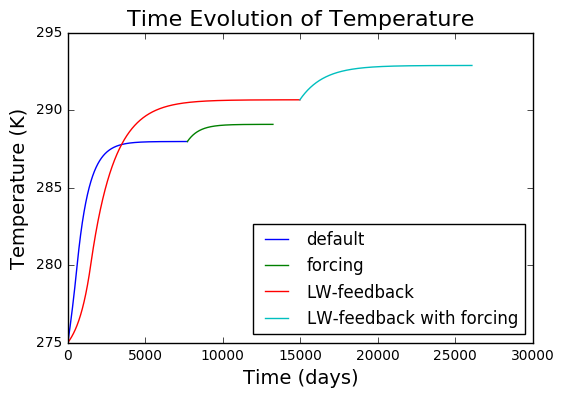

In [14]:
plt.title('Time Evolution of Temperature', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)
plt.plot(model_time_default, temp_series_default, label='default')
plt.plot(model_time_forcing, temp_series_forcing, label='forcing')
plt.plot(model_time_olr_lw_feedback, temp_series_olr_lw_feedback, label='LW-feedback')
plt.plot(model_time_olr_lw_feedback_forcing, temp_series_olr_lw_feedback_forcing, label='LW-feedback with forcing')
plt.legend(loc='best')

d. Discuss the differences between the control/doubled CO₂ temperatures for the two models (3a and 4a, 3b and 4b). 

The original OLR function rises much faster with temperature than the empirical OLR function. It means the former intersects with ASR at a lower temperature and therefore we reach equilibrium faster than the revised OLR function. It makes sense, because the latter implicitly includes LW feedback, which causes less outgoing radiation at higher temperature.

e. What is the climate sensitivity of this "LW-feedback" model? How does it compare to the climate sensitivity of the orginal model (Question 3)?  Why might these sensitivities be different?

In [15]:
print('Climate sensitivity (LW-feedback): {:0.2f} K'.format(equilibrium_temp_olr_lw_feedback_forcing - equilibrium_temp_olr_lw_feedback))

Climate sensitivity (LW-feedback): 2.22 K


Climate sensitivity is doubled using LW-feedback model.

## 5. ATS 521 only:

Add (pseudo-) random Gaussian noise to the temperature every time step to simulate stochastic processes (hint: the `random` module will be useful here). 

Use the **original** 0-D model (no LW feedbacks) with **no forcing**, and start with the **same set of initial conditions** you used in HW 1.

Plot and describe the behavior for different values of the standard deviation (in the Gaussian noise distribution).  You will probably want to run the models for longer to get a better sample of the behavior. Include at least one case within each of the following ranges:

a. For which values of the standard deviation do the temperatures essentially stay in either the warmer or colder states?

<font color=blue>_For standard deviation less than 0.5_</font>

b. For which values do the temperatures sometimes transition from one state to another? 

<font color=blue>_For standard deviation between 0.5 and 0.9_</font>

c. For which values do the stable equilibria seem to not matter?

<font color=blue>_For standard deviation greater than 0.9_</font>

d. Describe how the behavior changes as the standard deviation increases.

<font color=blue>_Increasing standard deviation adds more noise to the model and stops the temperature from moving consistently towards equilibrium. Probability of moving away from equilibrium is high with those values of standard deviation. It causes jumps between different equilibria. At very high standard deviations (>0.8), the model observes constant jumps with different states and would not reach a stable state. _</font>

e. Compare these standard deviation magnitudes to the difference between the model's two stable steady state temperatures.

<font color=blue>_Even though the difference between the two stable equilibria is much greater than the added noise, i.e. about 55K (T1=233K, T3=287.79K), the effect of noise is significant. As it can be seen in the examples below, even adding 0.6K to the model can force the final temperature to jump from one stable state to another.  _</font>

In [16]:
def calculate_temperature_with_noise(
    current_temperature,
    solar_constant=342,
    heat_capacity=2.2 * 10 ** 8,
    delta_time=1,
    temp_equilibrium_threshold=0.000001,
    max_steps=100000,
    mu=0,
    std=0.1
):
    """ Similar to `calculate_temperature`, but with random changes in temperature at each step.
    This function accepts 2 extra arguments used for generating random temperature:
    mu: mean
    std: standard deviation
    """
    delta_time = delta_time * 86400     # convert days to seconds
    delta_temp = 1                      # the initial temperature difference; an arbitrary value that makes sure the while loop below runs at least once
    steps = 0
    
    model_time=[]
    temp_series=[]

    while (abs(delta_temp) > temp_equilibrium_threshold) and steps < max_steps:
        temp_series.append(current_temperature)
        model_time.append(steps * delta_time / 86400)
        steps += 1
        radiative_flux = ASR(current_temperature, solar_constant) - OLR(current_temperature)
        delta_temp = radiative_flux * delta_time / heat_capacity
        current_temperature = current_temperature + delta_temp + np.random.normal(mu, std)

    return current_temperature, model_time, temp_series

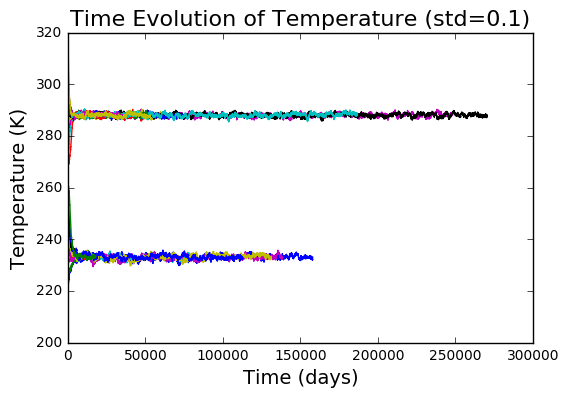

In [17]:
init_temps = np.linspace(220, 320, 20)   # list of initial conditions (K)

for temp in init_temps:
    equilibrium_temperature, model_time, temp_series = calculate_temperature_with_noise(temp, delta_time=10)
    plt.plot(model_time, temp_series)
plt.title('Time Evolution of Temperature (std=0.1)', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)

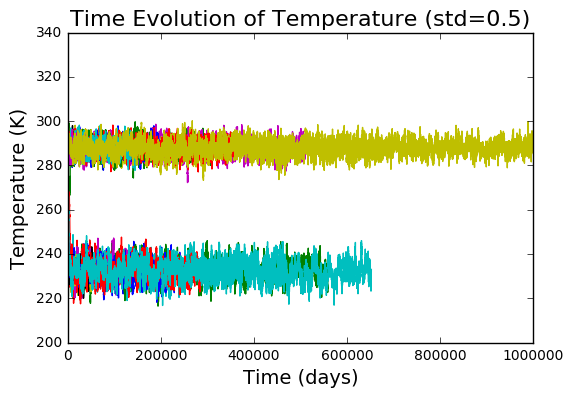

In [18]:
init_temps = np.linspace(220, 320, 20)   # list of initial conditions (K)

for temp in init_temps:
    equilibrium_temperature, model_time, temp_series = calculate_temperature_with_noise(temp, delta_time=10, std=0.5)
    plt.plot(model_time, temp_series)
plt.title('Time Evolution of Temperature (std=0.5)', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)

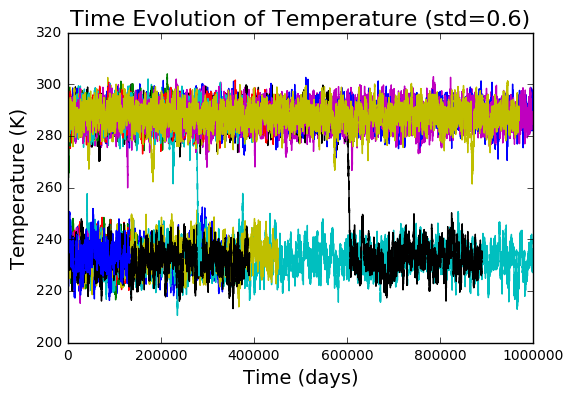

In [19]:
init_temps = np.linspace(220, 320, 20)   # list of initial conditions (K)

for temp in init_temps:
    equilibrium_temperature, model_time, temp_series = calculate_temperature_with_noise(temp, delta_time=10, std=0.61)
    plt.plot(model_time, temp_series)

plt.title('Time Evolution of Temperature (std=0.6)', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)

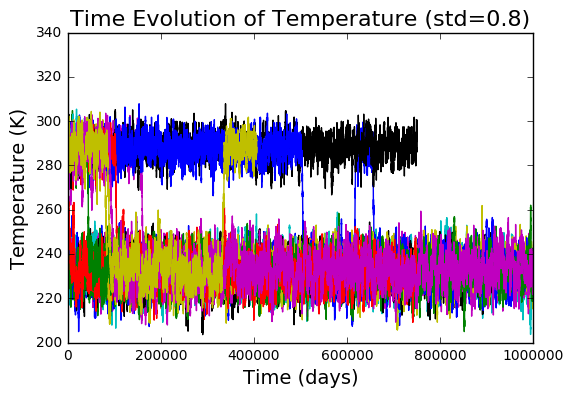

In [20]:
init_temps = np.linspace(220, 320, 20)   # list of initial conditions (K)

for temp in init_temps:
    equilibrium_temperature, model_time, temp_series = calculate_temperature_with_noise(temp, delta_time=10, std=0.8)
    plt.plot(model_time, temp_series)

plt.title('Time Evolution of Temperature (std=0.8)', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)

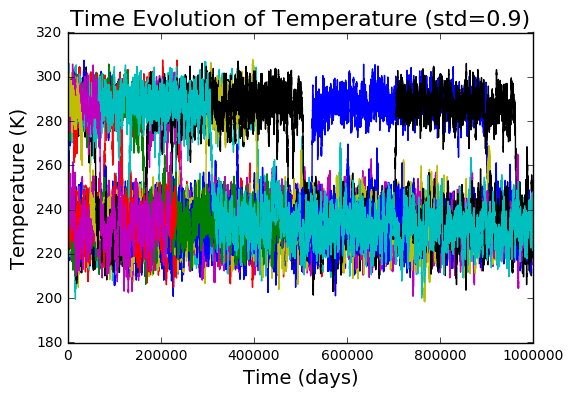

In [21]:
init_temps = np.linspace(220, 320, 20)   # list of initial conditions (K)

for temp in init_temps:
    equilibrium_temperature, model_time, temp_series = calculate_temperature_with_noise(temp, delta_time=10, std=0.9)
    plt.plot(model_time, temp_series)

plt.title('Time Evolution of Temperature (std=0.9)', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)

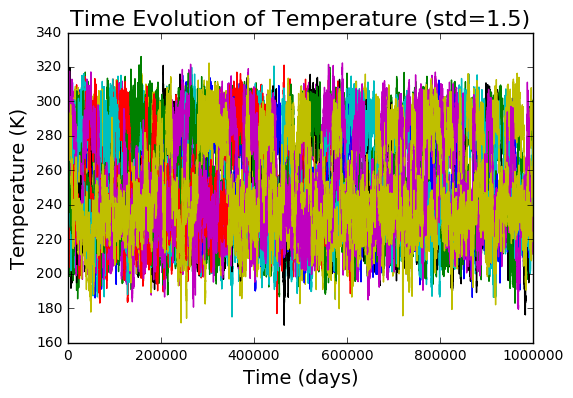

In [22]:
init_temps = np.linspace(220, 320, 20)   # list of initial conditions (K)

for temp in init_temps:
    equilibrium_temperature, model_time, temp_series = calculate_temperature_with_noise(temp, delta_time=10, std=1.5)
    plt.plot(model_time, temp_series)

plt.title('Time Evolution of Temperature (std=1.5)', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Temperature (K)',fontsize=14)

## Checklist

* Notebook re-runs correctly ("Kernel" -> "Restart and run all" works).
* All variables are commented with short variable decription (if not obvious from variable name) and units.
* Any functions include docstrings or sufficient commenting to describe inputs, outputs, and what it does.
* Include sufficient commenting in code that someone could look at portions and easily understand your methodology.
* Plots include titles, labels (with units) on x and y axes, and legends (if multiple lines). (Titles/legends are not necessary if they convey no more information than x and y axis labels.)
* Numerical values in Markdown or print statements include units.
* Answers to “compare,” “explain,” etc. questions are in complete sentences and grammatically correct. 